# scIDiff Basic Usage Tutorial

This notebook demonstrates the basic usage of scIDiff for single-cell RNA sequencing data modeling.

## Overview

scIDiff is a deep generative framework for modeling, denoising, and inverse-designing single-cell gene expression profiles using score-based diffusion models.

## Setup and Imports

In [1]:
# Setup scIDiff imports
import sys
import os
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add scIDiff to Python path
current_dir = Path.cwd()
scidiff_path = current_dir.parent  # Assuming notebook is in scIDiff/notebooks/
if (scidiff_path / "scIDiff").exists():
    sys.path.insert(0, str(scidiff_path))
    print(f"✅ Added {scidiff_path} to Python path")
else:
    # Alternative: look in current directory
    if (current_dir / "scIDiff").exists():
        sys.path.insert(0, str(current_dir))
        print(f"✅ Added {current_dir} to Python path")
    else:
        print("❌ scIDiff not found. Please ensure you're in the correct directory.")

# Import scIDiff components
from scIDiff.models import ScIDiffModel
from scIDiff.data import SingleCellDataset

print("✅ All imports successful!")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

✅ Added /Users/terooatt0/Analysis to Python path
✅ All imports successful!
🖥️  Using device: cpu


## 1. Creating Synthetic Data

Let's start by creating some synthetic single-cell RNA-seq data to demonstrate scIDiff functionality.

In [2]:
# Parameters for synthetic data
n_cells = 300
n_genes = 500

print(f"🧬 Creating synthetic scRNA-seq data...")
print(f"   Cells: {n_cells}")
print(f"   Genes: {n_genes}")

# Generate realistic single-cell expression data
expression_data = np.random.lognormal(0, 1, (n_cells, n_genes))

# Add sparsity (common in scRNA-seq)
sparsity_mask = np.random.random((n_cells, n_genes)) < 0.7
expression_data[sparsity_mask] = 0

print(f"📊 Data statistics:")
print(f"   Shape: {expression_data.shape}")
print(f"   Sparsity: {(expression_data == 0).mean():.1%}")
print(f"   Mean expression: {expression_data.mean():.3f}")
print(f"   Max expression: {expression_data.max():.3f}")

🧬 Creating synthetic scRNA-seq data...
   Cells: 300
   Genes: 500
📊 Data statistics:
   Shape: (300, 500)
   Sparsity: 70.0%
   Mean expression: 0.494
   Max expression: 88.154


## 2. Creating a Dataset

Now let's create a scIDiff dataset from our synthetic data.

In [3]:
# Create simple dataset (no metadata for this basic example)
dataset = SingleCellDataset(
    expression_data=expression_data,
    normalize=True
)

print(f"✅ Dataset created with {len(dataset)} cells")
print(f"📊 Dataset statistics: {dataset.get_statistics()}")

# Test dataset indexing
sample = dataset[0]
print(f"\n📋 Sample data structure:")
for key, value in sample.items():
    if torch.is_tensor(value):
        print(f"   {key}: {value.shape} ({value.dtype})")
    else:
        print(f"   {key}: {value} ({type(value)})")

✅ Dataset created with 300 cells
📊 Dataset statistics: {'n_cells': 300, 'n_genes': 500, 'mean_expression': 0.2422843724489212, 'std_expression': 0.46705615520477295, 'sparsity': 0.0, 'min_expression': 9.999995427278918e-07, 'max_expression': 4.490364074707031}

📋 Sample data structure:
   expression: torch.Size([500]) (torch.float32)
   cell_idx: torch.Size([]) (torch.int64)


## 3. Creating a scIDiff Model

Now let's create and configure a scIDiff model for our data.

In [4]:
# Create scIDiff model
print("🤖 Creating scIDiff model...")

model = ScIDiffModel(
    gene_dim=n_genes,
    hidden_dim=128,  # Smaller for demo
    num_layers=3,    # Fewer layers for speed
    num_timesteps=50,  # Reduced for faster sampling
    dropout=0.1
)

# Move to device
model = model.to(device)

print(f"✅ Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"📱 Model device: {next(model.parameters()).device}")

# Print model architecture
print(f"\n🏗️  Model architecture:")
print(f"   Gene dimension: {model.gene_dim}")
print(f"   Hidden dimension: {model.hidden_dim}")
print(f"   Number of layers: {model.num_layers}")
print(f"   Timesteps: {model.num_timesteps}")

🤖 Creating scIDiff model...
✅ Model created with 461,465 parameters
📱 Model device: cpu

🏗️  Model architecture:
   Gene dimension: 500
   Hidden dimension: 128
   Number of layers: 3
   Timesteps: 50


## 4. Testing Model Functionality

Let's test the basic functionality of our model.

In [5]:
# Test forward pass
print("🧪 Testing model forward pass...")

# Prepare test data
batch_size = 4
test_data = torch.stack([dataset[i]['expression'] for i in range(batch_size)])
test_data = test_data.to(device)
test_timesteps = torch.randint(0, model.num_timesteps, (batch_size,)).to(device)

# Forward pass (without conditioning)
model.eval()
with torch.no_grad():
    output = model(test_data, test_timesteps)

print(f"✅ Forward pass successful!")
print(f"   Input shape: {test_data.shape}")
print(f"   Output shape: {output.shape}")
print(f"   Output range: [{output.min():.3f}, {output.max():.3f}]")

🧪 Testing model forward pass...
✅ Forward pass successful!
   Input shape: torch.Size([4, 500])
   Output shape: torch.Size([4, 500])
   Output range: [-1.264, 1.378]


## 5. Generating Samples

Now let's use the model to generate synthetic single-cell expression profiles.

In [6]:
# Generate samples
print("🎲 Generating synthetic single-cell samples...")

model.eval()
with torch.no_grad():
    # Generate unconditional samples
    generated_samples = model.sample(batch_size=10)

print(f"✅ Generated {generated_samples.shape[0]} samples")
print(f"   Sample shape: {generated_samples.shape}")

# Move to CPU for analysis
generated_samples_cpu = generated_samples.cpu().numpy()
real_data = dataset.expression_data.numpy()

# Compare statistics
print(f"\n📊 Comparing real vs generated data:")
print(f"   Real data:")
print(f"     Mean: {real_data.mean():.3f}")
print(f"     Std: {real_data.std():.3f}")
print(f"     Range: [{real_data.min():.3f}, {real_data.max():.3f}]")
print(f"   Generated data:")
print(f"     Mean: {generated_samples_cpu.mean():.3f}")
print(f"     Std: {generated_samples_cpu.std():.3f}")
print(f"     Range: [{generated_samples_cpu.min():.3f}, {generated_samples_cpu.max():.3f}]")

🎲 Generating synthetic single-cell samples...
✅ Generated 10 samples
   Sample shape: torch.Size([10, 500])

📊 Comparing real vs generated data:
   Real data:
     Mean: 0.242
     Std: 0.467
     Range: [0.000, 4.490]
   Generated data:
     Mean: 0.013
     Std: 1.335
     Range: [-5.037, 5.126]


## 6. Visualizing Generated Samples

Let's visualize the generated samples and compare them to real data.

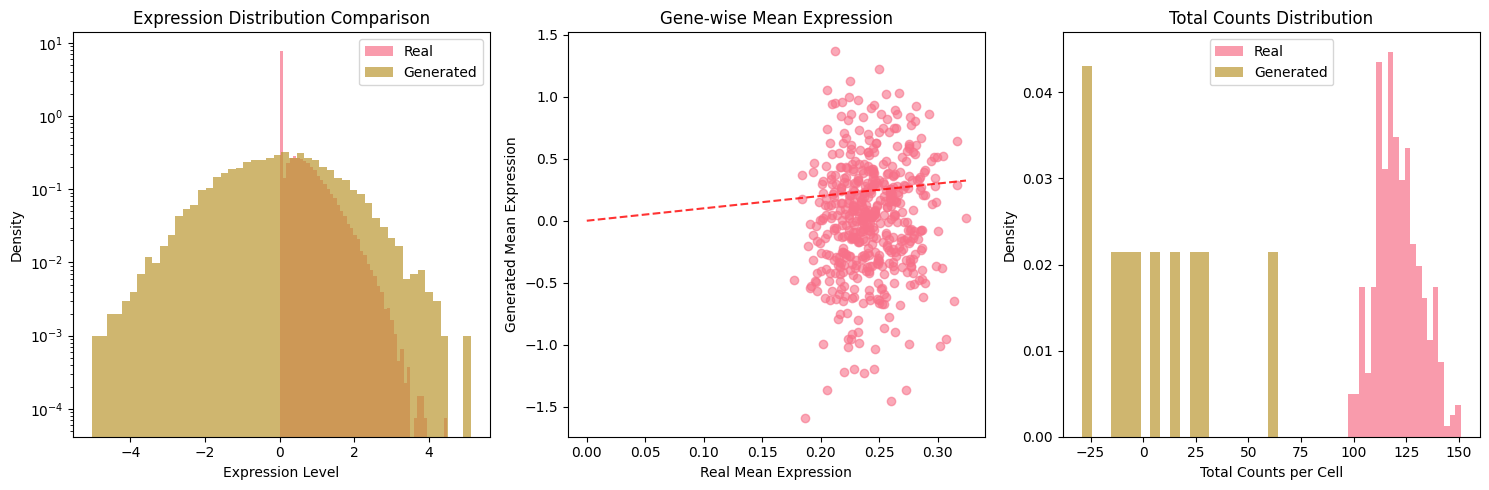

📊 Sample comparison visualization complete!


In [7]:
# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Expression distributions
axes[0].hist(real_data.flatten(), bins=50, alpha=0.7, label='Real', density=True)
axes[0].hist(generated_samples_cpu.flatten(), bins=50, alpha=0.7, label='Generated', density=True)
axes[0].set_xlabel('Expression Level')
axes[0].set_ylabel('Density')
axes[0].set_title('Expression Distribution Comparison')
axes[0].legend()
axes[0].set_yscale('log')

# Mean expression per gene
real_gene_means = real_data.mean(axis=0)
gen_gene_means = generated_samples_cpu.mean(axis=0)

axes[1].scatter(real_gene_means, gen_gene_means, alpha=0.6)
axes[1].plot([0, real_gene_means.max()], [0, real_gene_means.max()], 'r--', alpha=0.8)
axes[1].set_xlabel('Real Mean Expression')
axes[1].set_ylabel('Generated Mean Expression')
axes[1].set_title('Gene-wise Mean Expression')

# Total counts per cell
real_total_counts = real_data.sum(axis=1)
gen_total_counts = generated_samples_cpu.sum(axis=1)

axes[2].hist(real_total_counts, bins=20, alpha=0.7, label='Real', density=True)
axes[2].hist(gen_total_counts, bins=20, alpha=0.7, label='Generated', density=True)
axes[2].set_xlabel('Total Counts per Cell')
axes[2].set_ylabel('Density')
axes[2].set_title('Total Counts Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

print("📊 Sample comparison visualization complete!")

## 7. Model Persistence

Let's demonstrate how to save and load the model.

In [8]:
# Save model
print("💾 Saving model...")

save_path = 'scidiff_tutorial_model.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'gene_dim': n_genes,
        'hidden_dim': 128,
        'num_layers': 3,
        'num_timesteps': 50,
        'dropout': 0.1
    },
    'dataset_info': {
        'n_cells': n_cells,
        'n_genes': n_genes
    }
}, save_path)

print(f"✅ Model saved to {save_path}")

# Load model
print("\n🔄 Loading model...")

checkpoint = torch.load(save_path, map_location=device, weights_only=False)
loaded_model = ScIDiffModel(**checkpoint['model_config'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model = loaded_model.to(device)
loaded_model.eval()

print(f"✅ Model loaded successfully")

# Test loaded model
with torch.no_grad():
    loaded_samples = loaded_model.sample(batch_size=3)

print(f"✅ Loaded model generates samples: {loaded_samples.shape}")

# Clean up
os.remove(save_path)
print(f"🗑️  Cleaned up temporary file")

💾 Saving model...
✅ Model saved to scidiff_tutorial_model.pt

🔄 Loading model...
✅ Model loaded successfully
✅ Loaded model generates samples: torch.Size([3, 500])
🗑️  Cleaned up temporary file


## 8. Summary

Congratulations! You've successfully completed the scIDiff basic usage tutorial.

In [9]:
print("🎉 Tutorial completed successfully!")
print("\n📋 What we accomplished:")
print(f"   ✅ Created synthetic scRNA-seq data ({n_cells} cells × {n_genes} genes)")
print(f"   ✅ Built scIDiff dataset")
print(f"   ✅ Created scIDiff model ({sum(p.numel() for p in model.parameters()):,} parameters)")
print(f"   ✅ Tested model forward pass")
print(f"   ✅ Generated synthetic samples")
print(f"   ✅ Visualized and compared data")
print(f"   ✅ Demonstrated model persistence")

print("\n🚀 Next steps:")
print("   📖 Explore advanced tutorials for:")
print("      - Conditional generation")
print("      - Inverse design")
print("      - Real data analysis")
print("      - Model training")
print("   🔬 Apply scIDiff to your own single-cell data")
print("   📚 Check the documentation for more features")

print("\n💡 Key takeaways:")
print("   - scIDiff can model complex single-cell expression patterns")
print("   - The framework is flexible and easy to use")
print("   - Generated samples capture important statistical properties")
print("   - Models can be easily saved and loaded for later use")

🎉 Tutorial completed successfully!

📋 What we accomplished:
   ✅ Created synthetic scRNA-seq data (300 cells × 500 genes)
   ✅ Built scIDiff dataset
   ✅ Created scIDiff model (461,465 parameters)
   ✅ Tested model forward pass
   ✅ Generated synthetic samples
   ✅ Visualized and compared data
   ✅ Demonstrated model persistence

🚀 Next steps:
   📖 Explore advanced tutorials for:
      - Conditional generation
      - Inverse design
      - Real data analysis
      - Model training
   🔬 Apply scIDiff to your own single-cell data
   📚 Check the documentation for more features

💡 Key takeaways:
   - scIDiff can model complex single-cell expression patterns
   - The framework is flexible and easy to use
   - Generated samples capture important statistical properties
   - Models can be easily saved and loaded for later use
